<a href="https://colab.research.google.com/github/edenau/Machine-Learning-Climate-Parameterization/blob/master/work/NN/colab/SVM-6hrcumul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Virtual environment
#! export PATH="/scratch/$USER/miniconda/base/bin:$PATH"
#! source activate venv

import time
# MATLAB like tic toc
def TicTocGenerator():
    ti = 0
    tf = time.time()
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti
TicToc = TicTocGenerator() # create an instance of the TicTocGen generator
def toc(tempBool=True):
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: {:.1f} seconds.".format(tempTimeInterval) )
def tic():
    toc(False)
tic()

In [78]:
# Import pkg
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from math import floor, ceil
from sklearn import svm
import tensorflow as tf
print('All packages imported.')
toc()

All packages imported.
Elapsed time: 668.8 seconds.


In [4]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/gdrive')

# Check data list
!ls "/content/gdrive/My Drive/Colab Notebooks/data/"
!ls '/tmp'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
ARM_1hrlater.csv  ARM_6hrcumul.csv  ARM_no_dropna.cdf  ARM_strict_dropna.csv
drivefs_ipc.0  drivefs_ipc.0_shell


In [5]:
# Read data
DATADIR = '/content/gdrive/My Drive/Colab Notebooks/data'
#DATADIR = '../data/forNN'
f = DATADIR + '/ARM_6hrcumul.csv'
df = pd.read_csv(f,index_col=0) # the first column in .csv is index

# Double check NaN does not exist
print('There are {} NaN in the data.'.format(df.isnull().sum().sum()))
df

There are 0 NaN in the data.


,hour_cos,hour_sin,prec_sfc_6hrcumul,prec_sfc,T_p1000,T_p975,T_p950,T_p925,T_p900,T_p875,...,v_p325,v_p300,v_p275,v_p250,v_p225,v_p200,v_p175,v_p150,v_p125,v_p100
0,0.500000,8.660254e-01,0.257208,0.047667,299.979401,297.850006,295.649994,294.116669,292.449982,291.121796,...,-3.694841,-8.905457,-8.430822,-11.832866,-15.014605,-13.703352,-4.340648,3.429173,0.061024,-2.429142
1,0.866025,-5.000000e-01,0.300000,0.050000,299.540466,297.363037,295.245453,294.180420,295.295441,292.979156,...,3.635570,0.696846,-5.836888,-6.929137,-16.164400,-16.350965,-8.582373,2.699558,1.369764,2.531068
2,0.866025,-5.000000e-01,0.300492,0.050000,300.308807,297.945831,295.690002,293.509094,291.936371,292.528259,...,-0.570785,-6.294807,-5.568968,-2.439126,-3.171939,-3.827843,-1.925839,0.171745,4.252823,0.654523
3,0.866025,-5.000000e-01,0.300000,0.051311,299.845459,297.649994,295.542297,293.750000,292.582153,292.483337,...,-1.414140,-6.250647,-13.632689,-19.243462,-23.677080,-24.335115,-17.825041,-12.481750,3.124845,1.017899
4,0.866025,-5.000000e-01,0.300000,0.050000,299.509094,297.286346,295.541656,294.620270,292.957153,291.267487,...,-2.055194,-0.635155,0.038826,-0.884923,-3.075891,-3.622608,-4.358087,-0.225894,1.109643,-4.608153
5,0.866025,-5.000000e-01,0.301147,0.050000,299.473816,297.358337,295.208313,293.661438,293.036835,291.484985,...,-1.871192,0.079552,1.479049,-2.326284,-11.745255,-13.823651,-8.587365,-0.627821,4.487830,-2.143723
6,0.866025,-5.000000e-01,0.292109,0.980678,299.505005,297.845642,296.184784,295.038452,293.588470,291.712067,...,7.619709,7.176747,4.833903,-1.715490,-1.584804,-2.180600,-5.345045,6.249083,7.325176,0.537335
7,0.866025,-5.000000e-01,0.300169,0.048197,300.169037,297.968170,296.011902,294.509094,293.063629,292.125000,...,-3.801949,-1.510288,-0.065602,1.140482,1.721500,0.712793,-1.762484,-5.165653,-5.962721,-3.889105
8,0.866025,-5.000000e-01,0.309266,0.050339,299.997833,297.831818,296.725006,295.858582,294.429413,293.002930,...,0.789057,-4.094765,-8.825696,-11.111882,-13.857169,-13.698687,-9.175197,-2.952761,-4.772560,-6.912055
9,0.866025,-5.000000e-01,0.300983,0.050000,299.795441,297.564270,295.384979,293.574982,292.259094,291.237488,...,-0.079788,-3.749264,-5.678204,-9.683691,-10.290372,1.890432,9.836006,9.294689,-3.343925,-8.170444


In [0]:
# Generate inputs and labels
input = df.drop(columns='prec_sfc_6hrcumul')
raw_label = df['prec_sfc_6hrcumul']

# >0.31 mm in 6-hour period is counted as rainy
label = (raw_label.values > 0.31) *1 # ensure it is in int type

In [62]:
# Split data, deep copy to prevent contaminating raw data with standardization
train_size = 0.6
train_cnt = floor(input.shape[0] * train_size)

x_train = input.iloc[0:train_cnt].copy().values
y_train = label[0:train_cnt].copy()#.reshape([-1,1])
x_test = input.iloc[train_cnt:].copy().values
y_test = label[train_cnt:].copy().reshape([-1,1])

# Normalize data
INPUT_PRE_NORM = tf.placeholder("float", [None, None], name='pre_norm')
mean, variance = tf.nn.moments(INPUT_PRE_NORM, [0], name='moments') # batch normalization
std = tf.sqrt(variance)

NORM_MEAN = tf.placeholder("float", [None])
NORM_STD = tf.placeholder("float", [None])
normalized = (INPUT_PRE_NORM - NORM_MEAN) / NORM_STD
with tf.Session() as sess:
  # Normalize everything using mean/std of training data
  _mean, _std = sess.run([mean, std], feed_dict = {INPUT_PRE_NORM: x_train})
  x_train = sess.run(normalized, feed_dict = {INPUT_PRE_NORM: x_train,
                                              NORM_MEAN: _mean,
                                              NORM_STD: _std})
  # Double check _mean_0, _std_1 are all zeros and ones
  #_mean_0, _std_1 = sess.run([mean, std], feed_dict = {INPUT_PRE_NORM: x_train})
  #print(_mean_0, _std_1)

  x_test = sess.run(normalized, feed_dict = {INPUT_PRE_NORM: x_test,
                                             NORM_MEAN: _mean,
                                             NORM_STD: _std})

  # No normalization for labels
toc()

Elapsed time: 27.5 seconds.


gamma= 0.0010, test accuracy= 0.4868
gamma= 0.0011, test accuracy= 0.4972
gamma= 0.0012, test accuracy= 0.5034
gamma= 0.0013, test accuracy= 0.5059
gamma= 0.0015, test accuracy= 0.5116
gamma= 0.0016, test accuracy= 0.5163
gamma= 0.0018, test accuracy= 0.5157
gamma= 0.0019, test accuracy= 0.5178
gamma= 0.0021, test accuracy= 0.5214
gamma= 0.0023, test accuracy= 0.5199
gamma= 0.0026, test accuracy= 0.5225
gamma= 0.0028, test accuracy= 0.5250
gamma= 0.0031, test accuracy= 0.5292
gamma= 0.0034, test accuracy= 0.5323
gamma= 0.0037, test accuracy= 0.5333
gamma= 0.0041, test accuracy= 0.5323
gamma= 0.0045, test accuracy= 0.5343
gamma= 0.0049, test accuracy= 0.5312
gamma= 0.0054, test accuracy= 0.5323
gamma= 0.0060, test accuracy= 0.5302
gamma= 0.0066, test accuracy= 0.5266
gamma= 0.0072, test accuracy= 0.5281
gamma= 0.0079, test accuracy= 0.5271
gamma= 0.0087, test accuracy= 0.5245
gamma= 0.0095, test accuracy= 0.5209
gamma= 0.0105, test accuracy= 0.5178
gamma= 0.0115, test accuracy= 0.5147
g

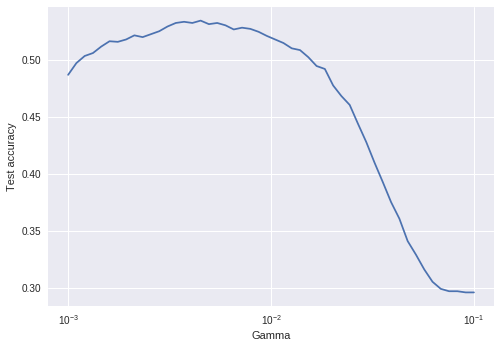

Elapsed time: 213.1 seconds.


In [85]:
# Build SVM with RBF kernel
scales = np.logspace(-3, -1, num=50, base=10)
cnt = -1
_accuracy = np.zeros(scales.size)

for scale in scales:
  clf = svm.SVC(gamma=scale) # RBF kernel by default
  clf = clf.fit(x_train, y_train)

  # Predict and calculate accuracy
  pred = clf.predict(x_test).reshape([-1,1])

  cnt += 1
  with tf.Session() as sess:
    PRED = tf.placeholder(tf.int32, [None,1])
    LABEL = tf.placeholder(tf.int32, [None,1])
    same = tf.equal(PRED, LABEL)
    accuracy = tf.reduce_mean(tf.cast(same, tf.float32))
  
    _accuracy[cnt] = sess.run(accuracy, feed_dict={PRED: pred, LABEL: y_test})

    print('gamma= {:.4f}, test accuracy= {:.4f}'.format(scale, _accuracy[cnt]))

plt.figure()
plt.plot(scales, _accuracy)
axes = plt.gca()
axes.set_xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Test accuracy')
plt.show()
toc()